In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%run dots_model.ipynb
%run dots_training_data.ipynb
%run TFSessionManager.ipynb

class Model:
    """
    Contains a TensorFlow graph which is suitable for learning the Tic Tac Toe Q function
    """

    def __init__(self, name: str, learning_rate: float):
        """
        Constructor for QNetwork. Takes a name and a learning rate for the GradientDescentOptimizer
        :param name: Name of the network
        :param learning_rate: Learning rate for the GradientDescentOptimizer
        """
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.predictions = None
        self.train_step = None
        self.loss = None
        self.optimizer = None
        self.correct_prediction = None
        self.accuracy = None
        self.output_logits = None
        self.x = None
        self.y = None
        self.net = None
        self.build_graph(name)
        #self.saver = tf.train.Saver()

    def build_graph(self, name: str):
        """
        Builds a new TensorFlow graph with scope `name`
        :param name: The scope for the graph. Needs to be unique for the session.
        """
        with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
            self.x = tf.placeholder(tf.float32, shape=[None, BOARD_EDGES], name='X')
            self.y = tf.placeholder(tf.float32, shape=[None, BOARD_EDGES], name='Y')

            self.net = self.x
            print(self.net)
            self.net = tf.layers.dense(self.net, BOARD_EDGES*BOARD_EDGES, tf.nn.relu,
                                           kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                           name='hidden')
            print(self.net)
            self.output_logits = tf.layers.dense(self.net, BOARD_EDGES, None,
                                           kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                           name='q_values')
            print(self.output_logits)
            self.predictions = tf.nn.softmax(self.output_logits, name='predictions')


            # Define the loss function, optimizer, and accuracy
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.output_logits), name='loss')
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate, name='Adam-op').minimize(self.loss)
            self.correct_prediction = tf.equal(tf.argmax(self.output_logits, 1), tf.argmax(self.y, 1), name='correct_pred')
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32), name='accuracy')

            #self.saver = tf.train.Saver()

class NNQPlayer(Player):
    """
    Implements a Tic Tac Toe player based on a Reinforcement Neural Network learning the Tic Tac Toe Q function
    """

    def board_state_to_nn_input(self, b) -> np.ndarray:
        """
        Converts a Tic Tac Tow board state to an input feature vector for the Neural Network. The input feature vector
        is a bit array of size 27. The first 9 bits are set to 1 on positions containing the player's pieces, the second
        9 bits are set to 1 on positions with our opponents pieces, and the final 9 bits are set on empty positions on
        the board.
        :param state: The board state that is to be converted to a feature vector.
        :return: The feature vector representing the input Tic Tac Toe board state.
        """
        return np.array(b)

    def __init__(self, name: str, reward_discount: float = 0.95, win_value: float = 1.0, draw_value: float = 0.0,
                 loss_value: float = -1.0, learning_rate: float = 0.01, training: bool = True):
        """
        Constructor for the Neural Network player.
        :param name: The name of the player. Also the name of its TensorFlow scope. Needs to be unique
        :param reward_discount: The factor by which we discount the maximum Q value of the following state
        :param win_value: The reward for winning a game
        :param draw_value: The reward for playing a draw
        :param loss_value: The reward for losing a game
        :param learning_rate: The learning rate of the Neural Network
        :param training: Flag indicating if the Neural Network should adjust its weights based on the game outcome
        (True), or just play the game without further adjusting its weights (False).
        """
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = Model(name, learning_rate)
        self.training = training
        super().__init__(name, BLACK) # FIX ME

    def new_game(self, side: int):
        """
        Prepares for a new games. Store which side we play and clear internal data structures for the last game.
        :param side: The side it will play in the new game.
        """
        self.side = side
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

    def calculate_targets(self) -> [np.ndarray]:
        """
        Based on the recorded moves, compute updated estimates of the Q values for the network to learn
        """
        game_length = len(self.action_log)
        targets = []

        for i in range(game_length):
            target = np.copy(self.values_log[i])

            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)

        #print(target)
        return targets

    def get_probs(self, input_pos: np.ndarray) -> ([float], [float]):
        """
        Feeds the feature vector `input_pos` which encodes a board state into the Neural Network and computes the
        Q values and corresponding probabilities for all moves (including illegal ones).
        :param input_pos: The feature vector to be fed into the Neural Network.
        :return: A tuple of probabilities and q values of all actions (including illegal ones).
        """
        probs, qvalues = TFSessionManager.get_session().run([self.nn.output_logits, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def select_move(self, board: Board):
        """
        Implements the Player interface and makes a move on Board `board`
        :param board: The Board to make a move on
        :return: A tuple of the GameResult and a flag indicating if the game is over after this move.
        """

        # We record all game positions to feed them into the NN for training with the corresponding updated Q
        # values.
        nn_input = self.board_state_to_nn_input(board.b)
        self.board_position_log.append(np.copy(nn_input))

        print("nn_input = {}".format(nn_input))
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        # We filter out all illegal moves by setting the probability to -1. We don't change the q values
        # as we don't want the NN to waste any effort of learning different Q values for moves that are illegal
        # anyway.
        #print("before " + str(probs))
        #print("valid " + str(board.valid_moves))
        for index, p in enumerate(qvalues):
            if not index in board.valid_moves:
            #if not board.is_legal(index):
                probs[index] = -1
        #print("after " + str(probs))

        # Our next move is the one with the highest probability after removing all illegal ones.
        move = np.argmax(probs)  # int
        #print("move=" + str(move))
        
        # Unless this is the very first move, the Q values of the selected move is also the max Q value of
        # the move that got the game from the previous state to this one.
        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[move])

        # We record the action we selected as well as the Q values of the current state for later use when
        # adjusting NN weights.
        self.action_log.append(move)
        self.values_log.append(qvalues)

        # We execute the move and return the result
        #_, res, finished = board.move(move, self.side)
        #return res, finished
        return move

    def final_result(self, winner):
        """
        This method is called once the game is over. If `self.training` is True, we execute a training run for
        the Neural Network.
        :param result: The result of the game that just finished.
        """

        # Compute the final reward based on the game outcome
        if (winner == self.ind):
            reward = self.win_value  # type: float
        else:
            reward = self.loss_value  # type: float

        #print("reward = " + str(reward))
        # The final reward is also the Q value we want to learn for the action that led to it.
        self.next_max_log.append(reward)

        # If we are in training mode we run the optimizer.
        if self.training:
            # We calculate our new estimate of what the true Q values are and feed that into the network as
            # learning target
            targets = self.calculate_targets()

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]

            print(self.nn.input)
            # We run the training step with the recorded inputs and new Q value targets.
            TFSessionManager.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})
            

def test_qplayer():
    tf.reset_default_graph()

    qplayer = NNQPlayer("qtest1", 0.01)
    
    with tf.Session() as sess:
        # Restore variables from disk.
        #saver.restore(sess, "/tmp/dots_model-9")

        greedy = GreedyPlayer("Greedy", BLACK)
        
        greedy.ind = 1
        qplayer.ind = 2
        
        for _ in range(1):
            g = Game(greedy, qplayer)
            winner = g.play_game()
            print(g.b.print_board())

    if false:
        toPlay = 2
        while (len(b.valid_moves) > 0):
            move = greedy.select_move(b)

            floats = [1.0 if x else 0.0 for x in b.b]
            labels = [0.0 if x == move else 0.0 for x in range(BOARD_EDGES)]

            if toPlay == 1:
                move = random.select_move(b)
                if not b.move(random.ind, move):
                    toPlay = 2
            else:
                # Run optimization op (backprop)
                feed_dict_batch = {x: [floats]}
                #predictions = sess.run([predictions, cls_prediction], feed_dict=feed_dict_batch)

                #print('before\n', b.print())
                qvalues, prediction = sess.run([predictions, cls_prediction], feed_dict={x: [floats]})

                q = qvalues[0]
                for index, p in enumerate(q):
                    #print(index)
                    if not index in b.valid_moves:
                        #print("dropping index ", str(index))
                        q[index] = -1

                move = np.argmax(q)  # int
                if not move in b.valid_moves:
                    print("best move is not legal!")
                    #print(b.valid_moves)
                    #print(q)

                print('before\n', b.print())
                if not b.move(greedy.ind, move):
                    toPlay = 1
                print('after\n', b.print())
        
print("start")
test_qplayer()
print("done")

Greedy won 10 matches, Random won 0
Greedy won 10 matches, Random won 0
start
Tensor("X:0", shape=(?, 32), dtype=float32)
Tensor("hidden/Relu:0", shape=(?, 1024), dtype=float32)
Tensor("q_values/BiasAdd:0", shape=(?, 32), dtype=float32)
nn_input = [False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False]


TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a NoneType into a Tensor.

In [ ]:
def test():
    tf.reset_default_graph()

    qplayer = NNQPlayer("Q")
    nn = qplayer.nn
    
    with tf.Session() as sess:
        # Restore variables from disk.
        #saver.restore(sess, "/tmp/dots_model-9")


        random = GreedyPlayer("Random", 1)
        greedy = GreedyPlayer("Greedy", 2)

        print("Hello")
        for _ in range(1):
            g = Game(random, greedy)
            b = g.board

            toPlay = 2
            while (len(b.valid_moves) > 0):
                move = greedy.select_move(b)

                floats = [1.0 if x else 0.0 for x in b.b]
                labels = [0.0 if x == move else 0.0 for x in range(BOARD_EDGES)]

                if toPlay == 1:
                    move = random.select_move(b)
                    if not b.move(random.ind, move):
                        toPlay = 2
                else:
                    # Run optimization op (backprop)
                    feed_dict_batch = {nn.x: [floats]}
                    #predictions = sess.run([predictions, cls_prediction], feed_dict=feed_dict_batch)

                    #print('before\n', b.print())
                    qvalues, prediction = sess.run([nn.predictions, nn.cls_prediction], feed_dict={nn.x: [floats]})

                    q = qvalues[0]
                    for index, p in enumerate(q):
                        #print(index)
                        if not index in b.valid_moves:
                            #print("dropping index ", str(index))
                            q[index] = -1

                    move = np.argmax(q)  # int
                    if not move in b.valid_moves:
                        print("best move is not legal!")
                        #print(b.valid_moves)
                        #print(q)

                    print('before\n', b.print())
                    if not b.move(greedy.ind, move):
                        toPlay = 1
                    print('after\n', b.print())
    print("done")



building Q
Tensor("X_1:0", shape=(?, 32), dtype=float32)
Tensor("hidden_1/Relu:0", shape=(?, 1024), dtype=float32)
Tensor("q_values_1/BiasAdd:0", shape=(?, 32), dtype=float32)
starting session
Training epoch: 1
iter   0:	 Loss=3.30,	Training Accuracy=17.1%
Training epoch: 2
iter   0:	 Loss=1.35,	Training Accuracy=62.4%
Training epoch: 3
iter   0:	 Loss=1.27,	Training Accuracy=63.9%
Training epoch: 4
iter   0:	 Loss=1.13,	Training Accuracy=69.9%
Training epoch: 5
iter   0:	 Loss=1.14,	Training Accuracy=67.6%
Training epoch: 6
iter   0:	 Loss=1.06,	Training Accuracy=68.6%
Training epoch: 7
iter   0:	 Loss=1.06,	Training Accuracy=68.1%
Training epoch: 8
iter   0:	 Loss=1.03,	Training Accuracy=69.3%
Training epoch: 9
iter   0:	 Loss=1.19,	Training Accuracy=63.9%
Training epoch: 10
iter   0:	 Loss=1.07,	Training Accuracy=68.6%


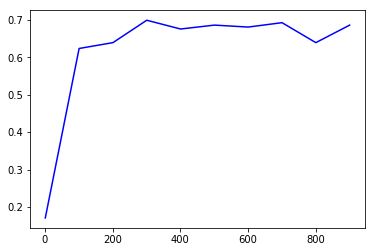

done


In [6]:
def get_next_batch(x_set, y_set, start, end):
    return x_set[start : end], y_set[start : end]

def build_and_save_model():
    print("building Q")
    qplayer = NNQPlayer("Q")
    nn = qplayer.nn

    epochs = 10            # Total number of training epochs
    batch_size = 1000        # Training batch size
    display_freq = 10000      # Frequency of displaying the training results

    # Create the op for initializing all variables
    init = tf.global_variables_initializer()

    accs = []
    iters = []

    starting_ind = 0

    print("starting session")
    # Launch the graph (session)
    #with tf.Session() as sess:
    sess = tf.Session()
    sess.run(init)
    writer = tf.summary.FileWriter('log', TFSessionManager.get_session().graph)
    global_step = 0
    # Number of training iterations in each epoch
    num_tr_iter = 100 #int(len(y_train) / batch_size)
    for epoch in range(epochs):
        print('Training epoch: {}'.format(epoch + 1))

        #x_train, y_train = randomize(x_train, y_train)
        for iteration in range(num_tr_iter):
            global_step += 1
            start = iteration * batch_size + starting_ind
            end = (iteration + 1) * batch_size + starting_ind
            #start = iteration * batch_size
            #end = (iteration + 1) * batch_size
            #x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
            x_batch, y_batch = generateData(batch_size)
            # Run optimization op (backprop)
            feed_dict_batch = {nn.x: x_batch, nn.y: y_batch}
            sess.run(nn.optimizer, feed_dict=feed_dict_batch)

            if iteration % display_freq == 0:
                # Calculate and display the batch loss and accuracy
                loss_batch, acc_batch = sess.run([nn.loss, nn.accuracy],
                                                 feed_dict=feed_dict_batch)

                accs.append(acc_batch)
                iters.append(global_step)

                print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                      format(iteration, loss_batch, acc_batch))

    p = plt.plot(iters, accs, 'b-')
    plt.show()

    #print("saving model")
    #save_path = saver.save(sess, "/tmp/dots_model", global_step=epoch)
    #print("Model saved in path: %s" % save_path)

    print('done')
    
build_and_save_model()
